### evaluate a model by draw prediction visually for a lond horizon

base: 11./evaluate_model_visualdraw

+ visualization of pitagemodel



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import indycar.model.evaluate_fulltest_fastrun as ev

INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU


## Load Data

In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/21.PaperReady'

#### evaluate

In [3]:
def plot_prob_forecasts(ts_entry, forecast_entry, outputfile):

    plot_length = context_length 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)

    #fig, axs = plt.subplots(figcnt, 1, figsize=(10, 7))

    #for idx in range(figcnt):

    #    ts_entry[idx][-plot_length:].plot(ax=axs[idx])  # plot the time series
    #    forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
    #    axs[idx].grid(which="both")
    #    axs[idx].legend(legend, loc="upper left")
    
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(10, 7))
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs)  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.savefig(outputfile + '-%d.pdf'%idx)
        plt.show()

def evaluate_model(predictor, evaluator, test_ds, outputfile):
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    
    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    #convert to univariate format
    # tss: <ts_len, #feature>
    # forecasts.sample: < 100, prediction_length, #feature>
   
    #tss_n = []
    #for ts in tss:
    #    tse = ts.to_numpy()
    #    tss_n.append(tse[:,0].reshape((tse.shape[0])))
    #cast_n = []
    #for fc in forecasts:
    #    nfc = fc
    #    fcs = fc.samples.shape
    #    nsamples = fc.samples[:,:,0].reshape((fcs[0], fcs[1]))
    #    nfc.samples = nsamples
    #    cast_n.append(nfc)
    #tss = tss_n
    #forecasts = cast_n


    # car12@rank1, car1@rank16, car7@rank33, the index is 7,0,4 accordingly
    # Indy500 Car 12 WillPower
    #offset = 52-7
    offset = 0
    ts_entry = [tss[7+offset],tss[0+offset],tss[4+offset]]
    forecast_entry = [forecasts[7+offset],forecasts[0+offset],forecasts[4+offset]]

    #debug
    #print(f'ts_entry shape:{ts_entry[0].shape}, forecast:{forecast_entry[0].samples.shape}')

    plot_prob_forecasts(ts_entry, forecast_entry, outputfile)
    
    #evaluator = MultivariateEvaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    
    
    print(json.dumps(agg_metrics, indent=4))
        

In [4]:
# construct long prediction result
def plot_prob_forecasts_ex(ts_entry, forecast_entry, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(20, 7))
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.savefig(outputfile + '-%d.pdf'%idx)
        plt.show()
        


def long_predict(output, halfwin = False):
    """
    input:
        test_ds
        predictor
    
    """
    
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print(first_start, last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    if halfwin:
    
        newsamples = np.zeros((2*nsample, last_start - first_start + npredict))

        blockid = 0
        for idx in range(len(forecasts)):
            #copy samples
            start_pos = get_start(idx)

            pos = start_pos - first_start
            #copy sample to block
            newsamples[nsample*blockid: nsample*blockid + nsample, pos:pos + npredict] = forecasts[idx].samples

            blockid = (blockid + 1) % 2

        #first block
        newsamples[nsample*blockid: nsample*blockid + nsample, 0:0 + npredict] = forecasts[-1].samples

        #last block
        blockid = 1
        newsamples[nsample*blockid: nsample*blockid + nsample, last_start- first_start:last_start- first_start + npredict] = forecasts[0].samples
        
    else:
        newsamples = np.zeros((nsample, last_start - first_start + npredict))

        for idx in range(len(forecasts)):
            #copy samples
            start_pos = get_start(idx)

            pos = start_pos - first_start
            #copy sample to block
            newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        

    target.samples = newsamples

    plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target

### evaluate

In [5]:
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}


In [6]:
prediction_length = 2
freq = '1min'

In [9]:
ev._dataset_id = 'indy2013-2018-nocarid'
ev._dataset_id = 'indy2013-2018'
#_test_event = 'Indy500-2019'
ev._test_event = 'Indy500-2018'

ev._task_id = 'rank'  # rank,laptime, the trained model's task
ev._run_ts = ev.COL_RANK   #COL_LAPTIME,COL_RANK
ev._exp_id='rank'  #rank, laptime, laptim2rank, timediff2rank... 

ev._feature_mode = ev.FEATURE_STATUS
ev._context_ratio = 0.

ev.init()

In [10]:
#ev._dataset_id = 'indy2013-2018-pitagemodel'
#ev._test_event = 'Indy500-2018'
##_test_event = 'Indy500-2019'

#ev._feature_mode = ev.FEATURE_TRACKONLY
#ev._context_ratio = 0.

##rootdir = f'../models/remote/{_dataset_id}/{_task_id}-{trainid}/'
#ev._task_id = 'pitage'  # rank,laptime, the trained model's task
#ev._run_ts = ev.COL_LAPS_INSTINT   #COL_LAPTIME,COL_RANK
#ev._exp_id='pitage'  #rank, laptime, laptim2rank, timediff2rank... 

#ev.init()



In [11]:
test_cars = [12]
save_prefix = 'test-' + ev._test_event + '_'.join([str(x) for x in test_cars])
outputfile = 'output'

In [12]:
train_ds, test_ds,_,_ = ev.make_dataset_byevent(events_id[ev._test_event], prediction_length,freq, 
                                     oracle_mode=ev.MODE_ORACLE,
                                     run_ts = ev._run_ts,
                                     test_event = ev._test_event,
                                     test_cars=test_cars,
                                     half_moving_win = 2,
                                     train_ratio = 0.4)


train len:0, test len:94, mae_track:0.0,mae_lap:0.0,


INFO:root:Using GPU


predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
tss len=94, forecasts len=94
12 198
sampel# x predictlen:  100 2


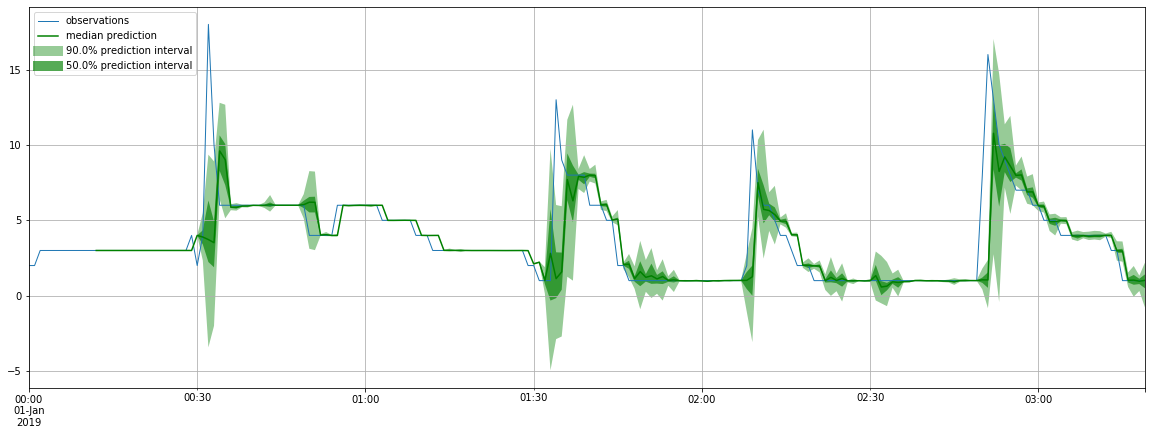

In [13]:
#ev._dataset_id = 'indy2013-2018-pitagemodel-context40'
predictor = ev.load_model('oracle', '2018',prediction_length)
target = long_predict('deepAR-Oracle-context40-nextpit')

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=94, forecasts len=94
12 198
sampel# x predictlen:  100 2


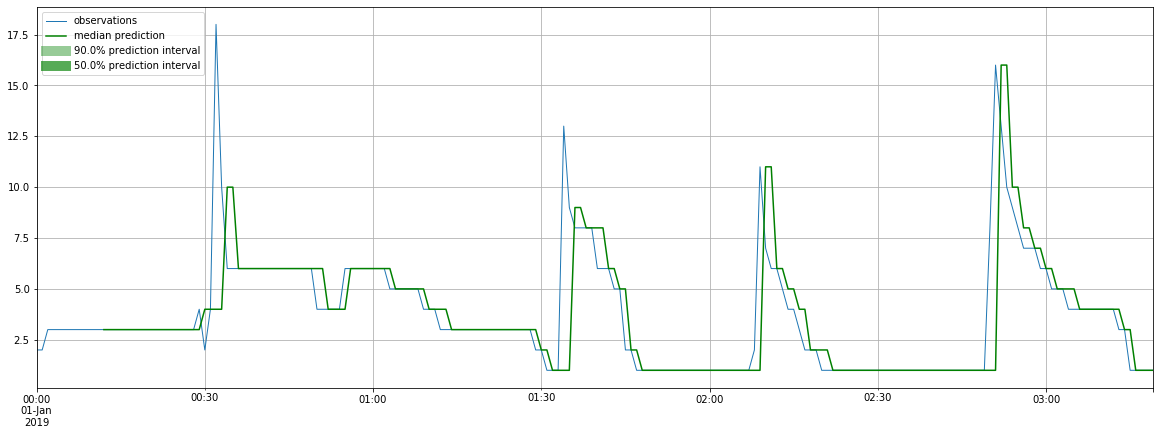

In [14]:
#load predictor
#model='naive-vspeed-nolap-indy-f1min-t10-e1000-r1'
#modeldir = '../models/' + model
#predictor =  Predictor.deserialize(Path(modeldir))
predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)
target = long_predict('naive-vspeed')

In [15]:
predictor =  RForecastPredictor(method_name='arima',freq= freq, 
                                            prediction_length = prediction_length,trunc_length=40)
target_deepar = long_predict('arima-rank')

ImportError: libR.so: cannot open shared object file: No such file or directory
The RForecastPredictor is a thin wrapper for calling the R forecast package.
In order to use it you need to install R and run

pip install 'rpy2>=2.9.*,<3.*'

R -e 'install.packages(c("forecast", "nnfor"), repos="https://cloud.r-project.org")'


INFO:root:Using GPU


predicting model=deepARW-oracle, plen=2
loading model...done!, ctx:gpu(0)
tss len=94, forecasts len=94
12 198
sampel# x predictlen:  100 2


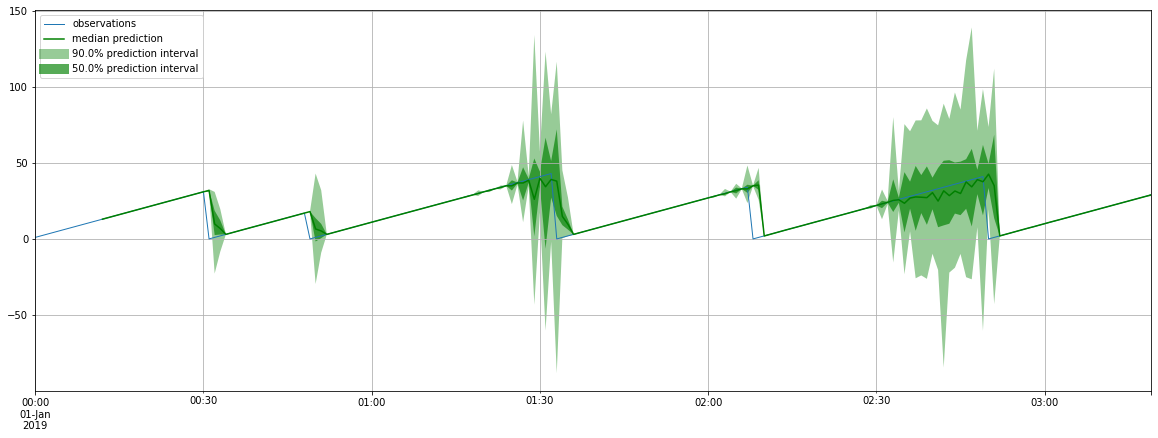

In [16]:
ev._dataset_id = 'indy2013-2018-deeparw'
predictor = ev.load_model('deepARW-oracle', '2018',prediction_length)
target_deepar = long_predict('deepARW-Oracle-pitage')

INFO:root:Using GPU


predicting model=deepARW-oracle, plen=2
loading model...done!, ctx:gpu(0)
tss len=94, forecasts len=94
12 198
sampel# x predictlen:  100 2


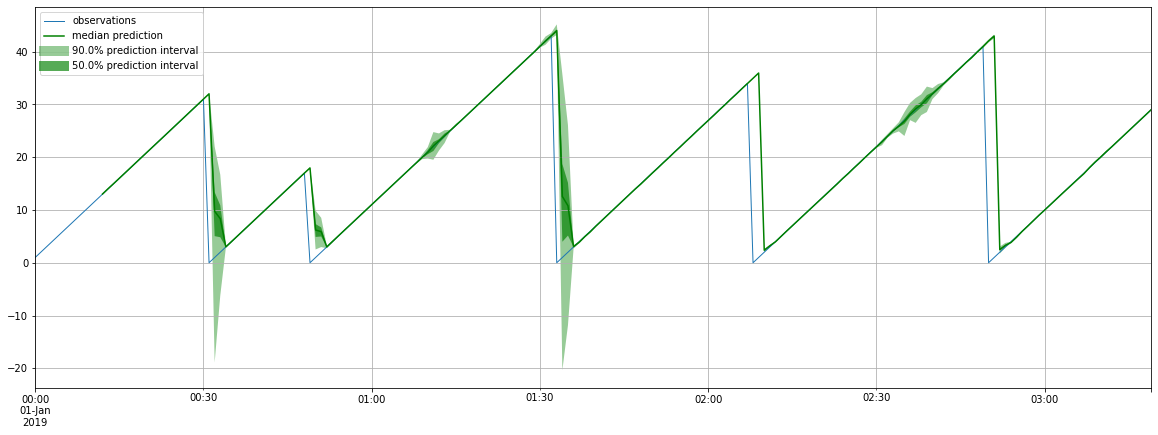

In [17]:
ev._dataset_id = 'indy2013-2018-deeparw-nocarid-context40'
predictor = ev.load_model('deepARW-oracle', '2018',prediction_length)
target = long_predict('deepAR-Oracle-pitage')

INFO:root:Using GPU


predicting model=deepARW-oracle, plen=2
loading model...done!, ctx:gpu(0)
tss len=94, forecasts len=94
12 198
sampel# x predictlen:  100 2


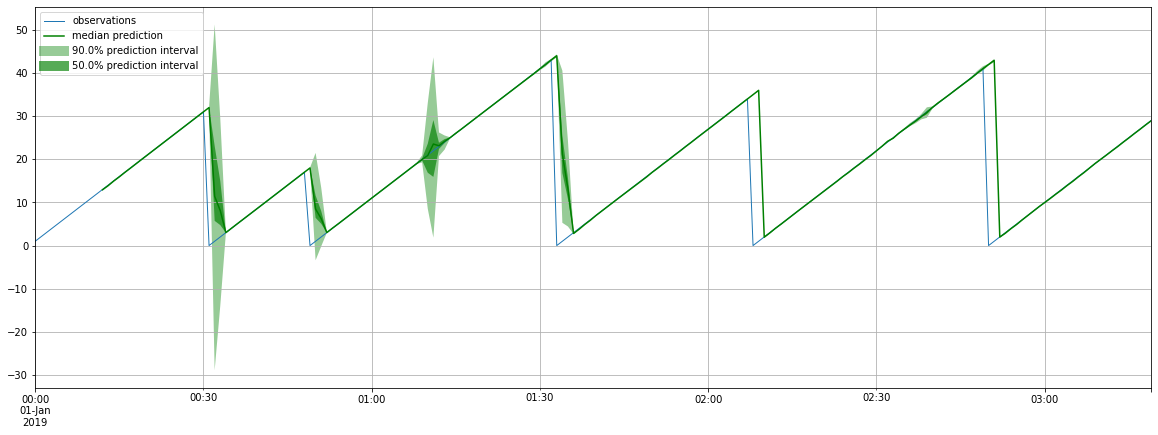

In [18]:
ev._dataset_id = 'indy2013-2018-deeparw-context40'
predictor = ev.load_model('deepARW-oracle', '2018',prediction_length)
target = long_predict('deepAR-Oracle-pitage')

INFO:root:Using GPU


predicting model=deepARW, plen=2
loading model...done!, ctx:gpu(0)
tss len=94, forecasts len=94
12 198
sampel# x predictlen:  100 2


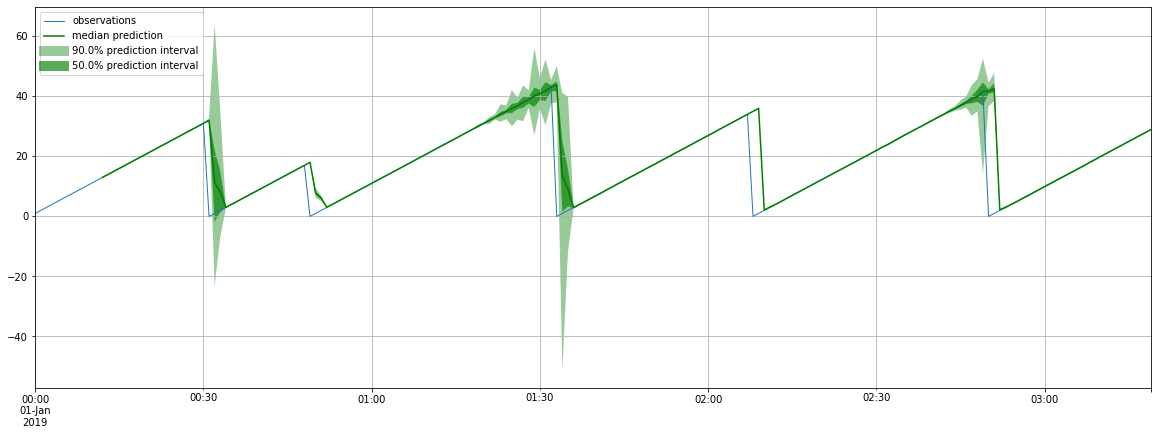

In [19]:
ev._dataset_id = 'indy2013-2018-deeparw-context40'
predictor = ev.load_model('deepARW', '2018',prediction_length)
target = long_predict('deepAR-Oracle-pitage')

### test

In [20]:
prediction_length = 10
context_length = 20
model='deepAR-Oracle-vspeed-nolap-indy-f1min-t10-e1000-r1'
freq = "1min"

cardinality = [len(global_carids)]
interpolate = False
ipstr = '' if interpolate else '-noip'
test_cars = [12]
test_event = 'Indy500'
save_prefix = 'test-' + test_event + '_'.join([str(x) for x in test_cars])
outputfile = 'output'
#make_gluontsdb(events_id[test_event])

train_ds, test_ds,_,_ = make_dataset(events_id[test_event], prediction_length,freq, oracle_mode=MODE_NOLAP,
                                         interpolate=interpolate,test_cars=test_cars)

#get target dim
entry = next(iter(train_ds))
target_dim = entry['target'].shape
target_dim = target_dim[0] if len(target_dim) > 1 else 1
print('target_dim:%s', target_dim)

NameError: name 'global_carids' is not defined

In [ ]:
#if target_dim > 1:
#    evaluator = MultivariateEvaluator(quantiles=[0.1, 0.5, 0.9])
#else:
#    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

evaluate_model(predictor, evaluator, test_ds, outputfile)

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

forecasts = list(forecast_it)
tss = list(ts_it)
print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')

In [ ]:
tsslen = [len(tss[x]) for x in range(len(tss))]
print(tsslen[-1])
np.mean(tsslen)

In [ ]:
start_time, row = next(tss[0].iterrows())
start_time

In [ ]:
fstart = [forecasts[x].start_date for x in range(len(forecasts))]

In [ ]:
fstart

In [ ]:
td = forecasts[-1].start_date - start_time

In [ ]:
td.days*24*60 + td.seconds//60

In [ ]:
len(tss[-1])

In [ ]:
forecasts[0]

In [ ]:
forecasts[0].samples.shape

In [ ]:
def get_start(idx):
    td = forecasts[idx].start_date - start_time
    return td.days*24*60 + td.seconds//60
    

first_start = get_start(-1)
last_start = get_start(0)
print(first_start, last_start)

In [ ]:
import copy
target = copy.deepcopy(forecasts[-1])

In [ ]:
target

In [ ]:
#100, 10
nsample, npredict = target.samples.shape
print('sampel# x predictlen: ', nsample, npredict)
newsamples = np.zeros((2*nsample, last_start - first_start + npredict))

blockid = 0
for idx in range(len(forecasts)):
    #copy samples
    start_pos = get_start(idx)
    
    pos = start_pos - first_start
    #copy sample to block
    newsamples[nsample*blockid: nsample*blockid + nsample, pos:pos + npredict] = forecasts[idx].samples
    
    blockid = (blockid + 1) % 2
    
#first block
newsamples[nsample*blockid: nsample*blockid + nsample, 0:0 + npredict] = forecasts[-1].samples

#last block
blockid = 1
newsamples[nsample*blockid: nsample*blockid + nsample, last_start- first_start:last_start- first_start + npredict] = forecasts[0].samples


    

In [ ]:
newsamples.shape

In [ ]:
target.samples = newsamples
target

In [ ]:
target.samples.shape

In [ ]:
context_length = 0
plot_prob_forecasts_ex([tss[0]],[target],'output')

In [ ]:
a=np.array([2,3,4,5,0,2,0])
(a>0)*0.1 + (a==0)* 1
